# Energy Efficiency <br>

Data source: https://archive.ics.uci.edu/dataset/242/energy+efficiency

It contains 768 samples, with 8 independent variables and 2 dependent variables. These independent variables are building parameters. The dependent variables are the heating and cooling loads for those buildings.

## Problem Description <br>

Here’s a revised version of the passage:

According to Energy.gov, heating, ventilation, and air conditioning (HVAC) systems account for approximately 35% of a building’s energy consumption. Given the substantial amount of time people spend indoors, both at home and in workplaces, it is increasingly important to prioritize system designs that provide comfortable, cost-effective, and safe environments.

The aim of our study is to explore whether machine learning can accurately predict heating and cooling loads based on basic building parameters, with the goal of creating more energy-efficient buildings. Using a dataset from UCI, which includes known heating loads (HL) and cooling loads (CL), we will examine the influence of eight input variables: relative compactness (X1), surface area (X2), wall area (X3), roof area (X4), overall height (X5), orientation (X6), glazing area (X7), and glazing area distribution (X8). A supervised regression model will be employed to predict the expected heating and cooling loads.


KPIs:

- Energy load measurements: <b>y1(Heating load)</b> and <b>y2(Cooling load)</b><br>
- Energy load below 20 = low<br>
- Energy load between 30 and 40 = medium <br>
- Energy load 40 and greater =  high<br>

## Data Dictionary <br>

Column  |  Name  |  Data Type | Description
-----|------------|--------|--------
X1  | Relative Compactness | float | unk <br>
X2  | Surface Area | float | sum of areas of walls and roof  <br>
X3  | Wall Area | float | sum of areas of walls <br>
X4  | Roof Area | float | area of roof <br>
X5  | Overall Height | float | 1 or 2 story tall <br>
X6  | Orientation | int | North, South, East, West <br>
X7  | Glazing Area | float | unk <br>
X8  | Glazing Area Distribution | int | unk  <br>
y1  | Heating Load | float | Energy cost to heat building <br>
y2  | Cooling Load | float | Energy cost to cool building <br>

In [1]:
# Load libraries
import pandas as pd
import numpy as np 

#For data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#For datascience 
from sklearn.model_selection import train_test_split, cross_validate, KFold,cross_val_predict,learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
from ucimlrepo import fetch_ucirepo

In [4]:
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# metadata 
print(energy_efficiency.metadata) 
  
# variable information 
print(energy_efficiency.variables)

{'uci_id': 242, 'name': 'Energy Efficiency', 'repository_url': 'https://archive.ics.uci.edu/dataset/242/energy+efficiency', 'data_url': 'https://archive.ics.uci.edu/static/public/242/data.csv', 'abstract': 'This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 768, 'num_features': 8, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y1', 'Y2'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C51307', 'creators': ['Athanasios Tsanas', 'Angeliki Xifara'], 'intro_paper': {'ID': 379, 'type': 'NATIVE', 'title': 'Accurate quantitative estimation of energy performance of residential buildings using statistical machine 

In [5]:
#Get the data

url = 'https://raw.githubusercontent.com/pythonandmore/EnergyEfficiency/main/ENB2012_data.csv'
data = pd.read_csv(url)
data.head()


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [6]:
#Identify null values
print('Null Values =', data.isnull().values.any())

Null Values = False


In [7]:
#Drop unwanted columns
dataset=data[['X1','X2','X3','X4','X5','X6','X7','X8','Y1','Y2']]
dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [8]:
#Identify null values

print('Null Values =', dataset.isnull().values.any())

Null Values = False


In [9]:
# Drop null values in rows 
dataset.dropna(how='all', inplace=True)
# Drop null values in columns
#dataset.dropna(axis=1, inplace=True)

# Data cleaning

In [10]:
# Drop unnamed columns for data cleaning improved visualization
df = dataset[['X1','X2','X3','X4','X5','X6','X7','X8','Y1','Y2']].rename({'X1':'Compactness','X2':'Surface Area','X3':'Wall Area','X4':'Roof Area','X5':'Height','X6':'Orientation','X7':'Glazing Area','X8':'Glazing Area dist','Y1':'Heating load','Y2':'Cooling load'},axis=1,inplace=False)
df2=dataset[['X1','X3','X4','X6','X7','X8','Y1','Y2']]
#df_final
#df = df.astype(int)
#df.drop("Unnamed: 10", axis=1, inplace=True)
df.head()

,Compactness,Surface Area,Wall Area,Roof Area,Height,Orientation,Glazing Area,Glazing Area dist,Heating load,Cooling load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [11]:
df.describe()

,Compactness,Surface Area,Wall Area,Roof Area,Height,Orientation,Glazing Area,Glazing Area dist,Heating load,Cooling load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


## Data Visualization

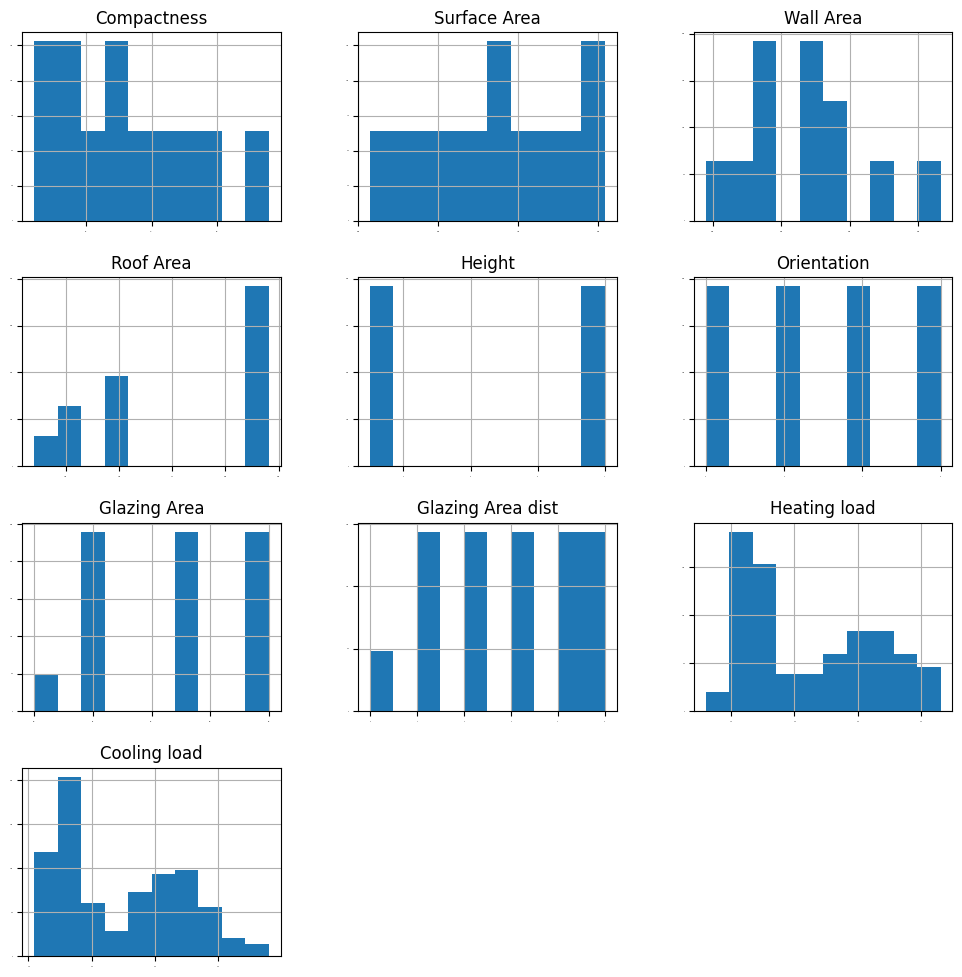

In [12]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

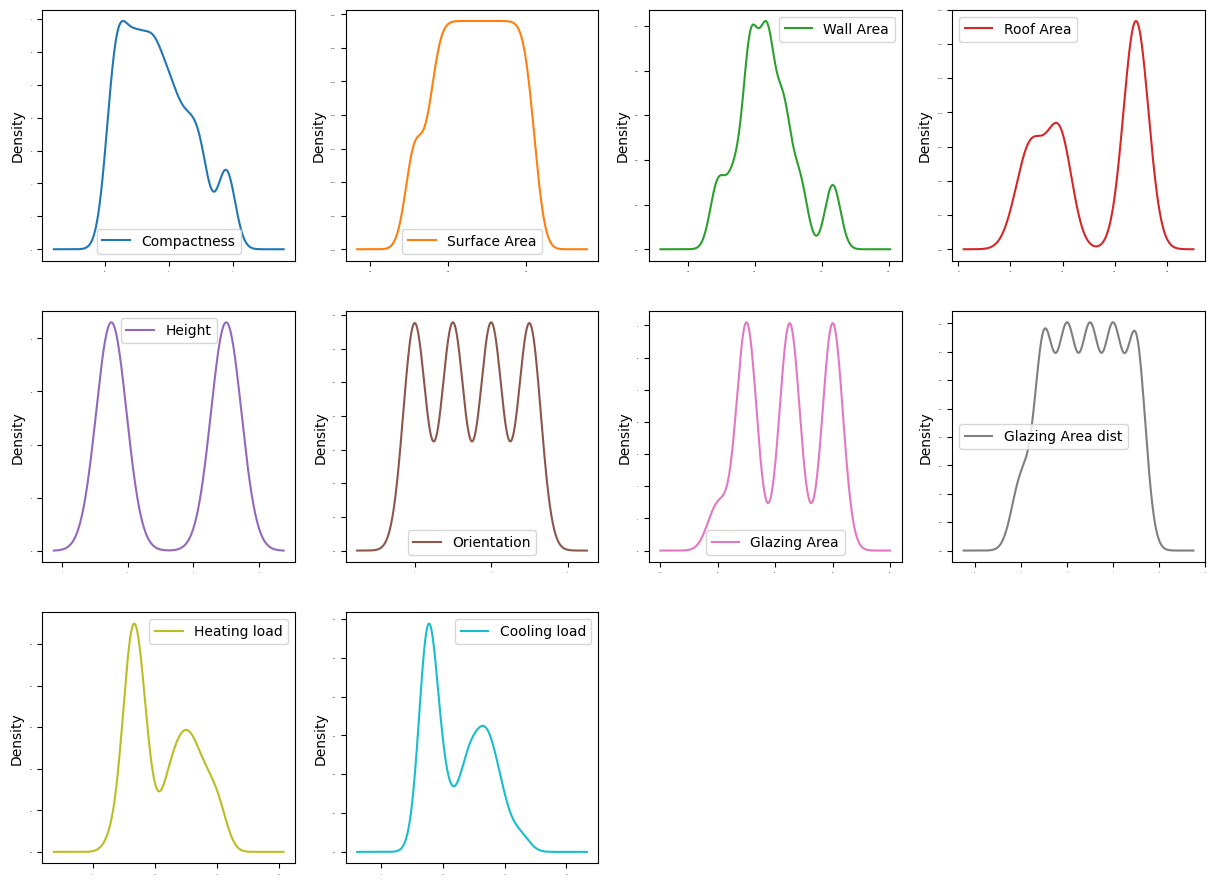

In [13]:
# density
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
plt.show()

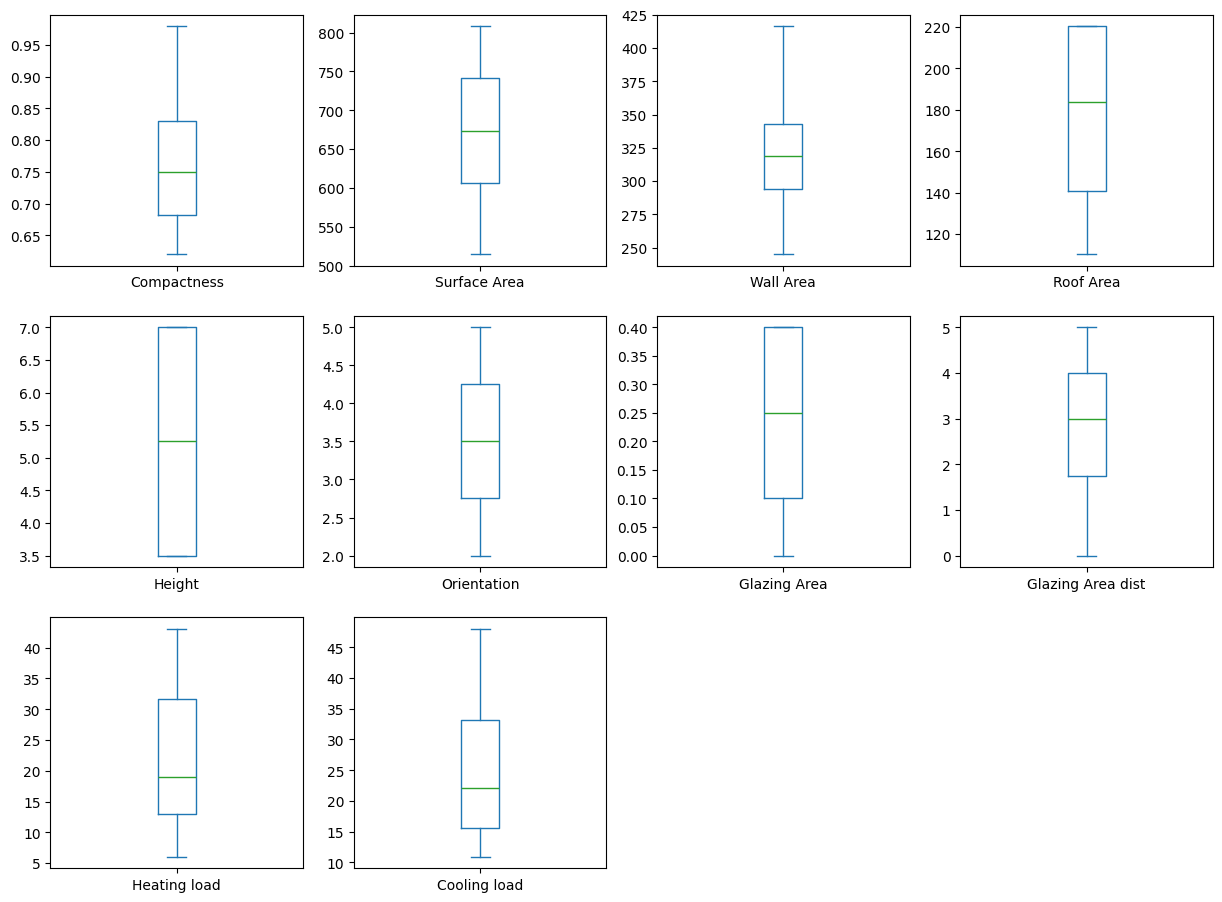

In [14]:
#Box and Whisker Plots
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

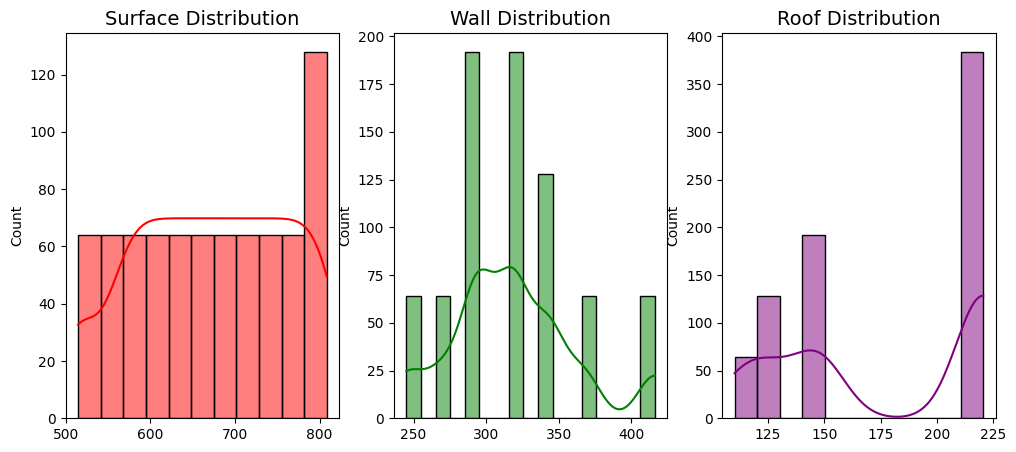

In [15]:
# Visualizations to show area distribution 
fig , ax = plt.subplots(1,3,figsize = (12,5))

SurfaceArea = dataset.X2.values
WallArea= dataset.X3.values
RoofArea = dataset.X4.values

sns.histplot(SurfaceArea , ax = ax[0] , color = 'red', kde = True).set_title('Surface Distribution' , fontsize = 14)
sns.histplot(WallArea , ax = ax[1] , color = 'green', kde = True).set_title('Wall Distribution' , fontsize = 14)
sns.histplot(RoofArea , ax = ax[2] , color = 'purple', kde = True).set_title('Roof Distribution' , fontsize = 14)

plt.show()

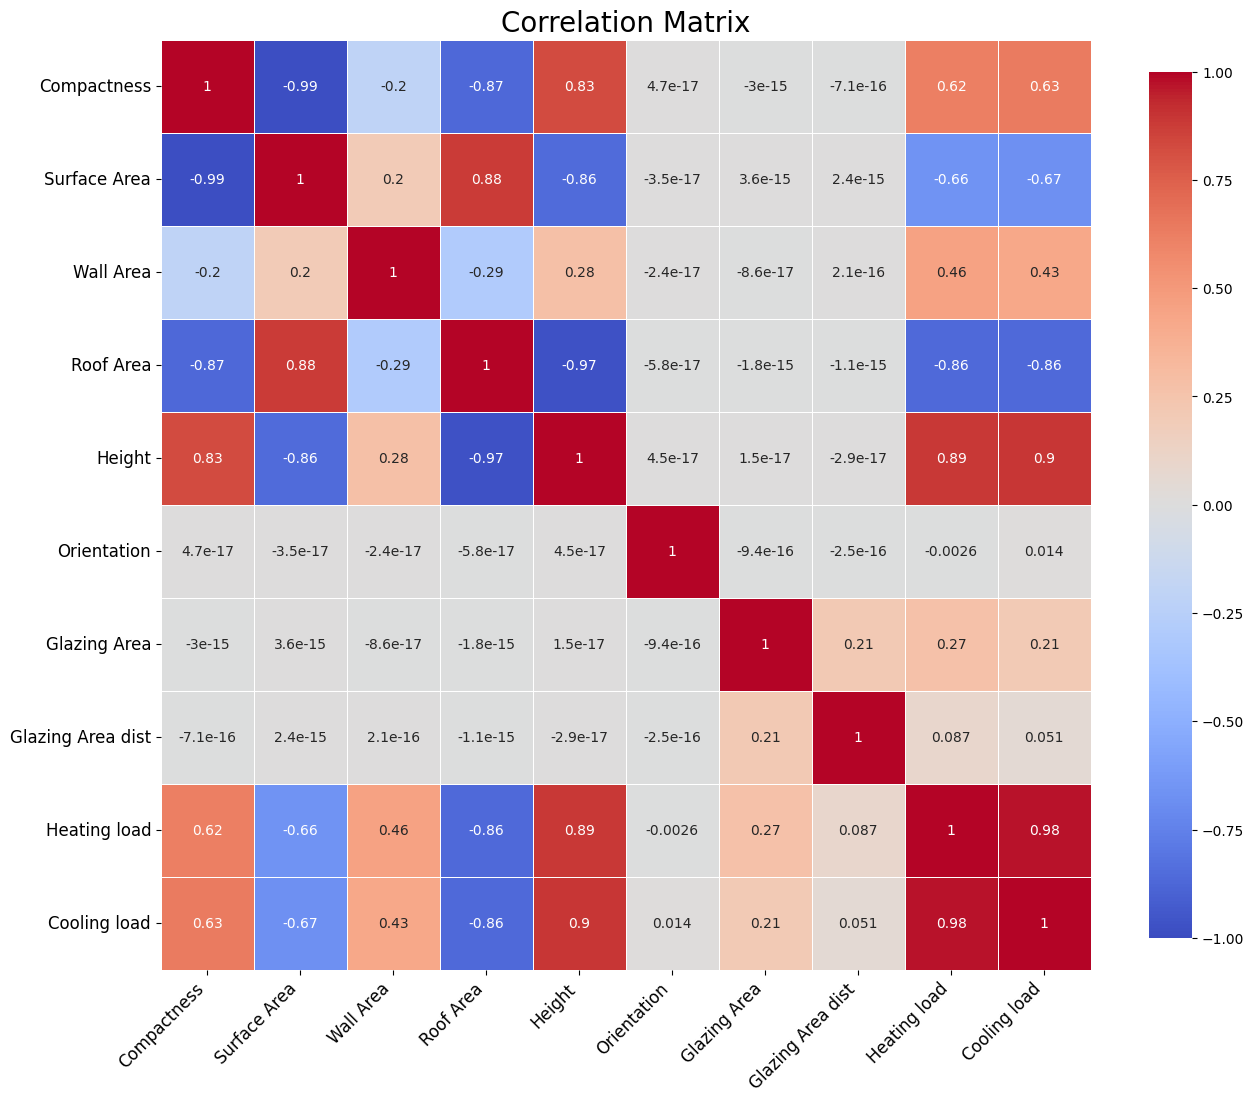

In [16]:
# correlation
correlation = df.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix', fontsize=20)
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .75})
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

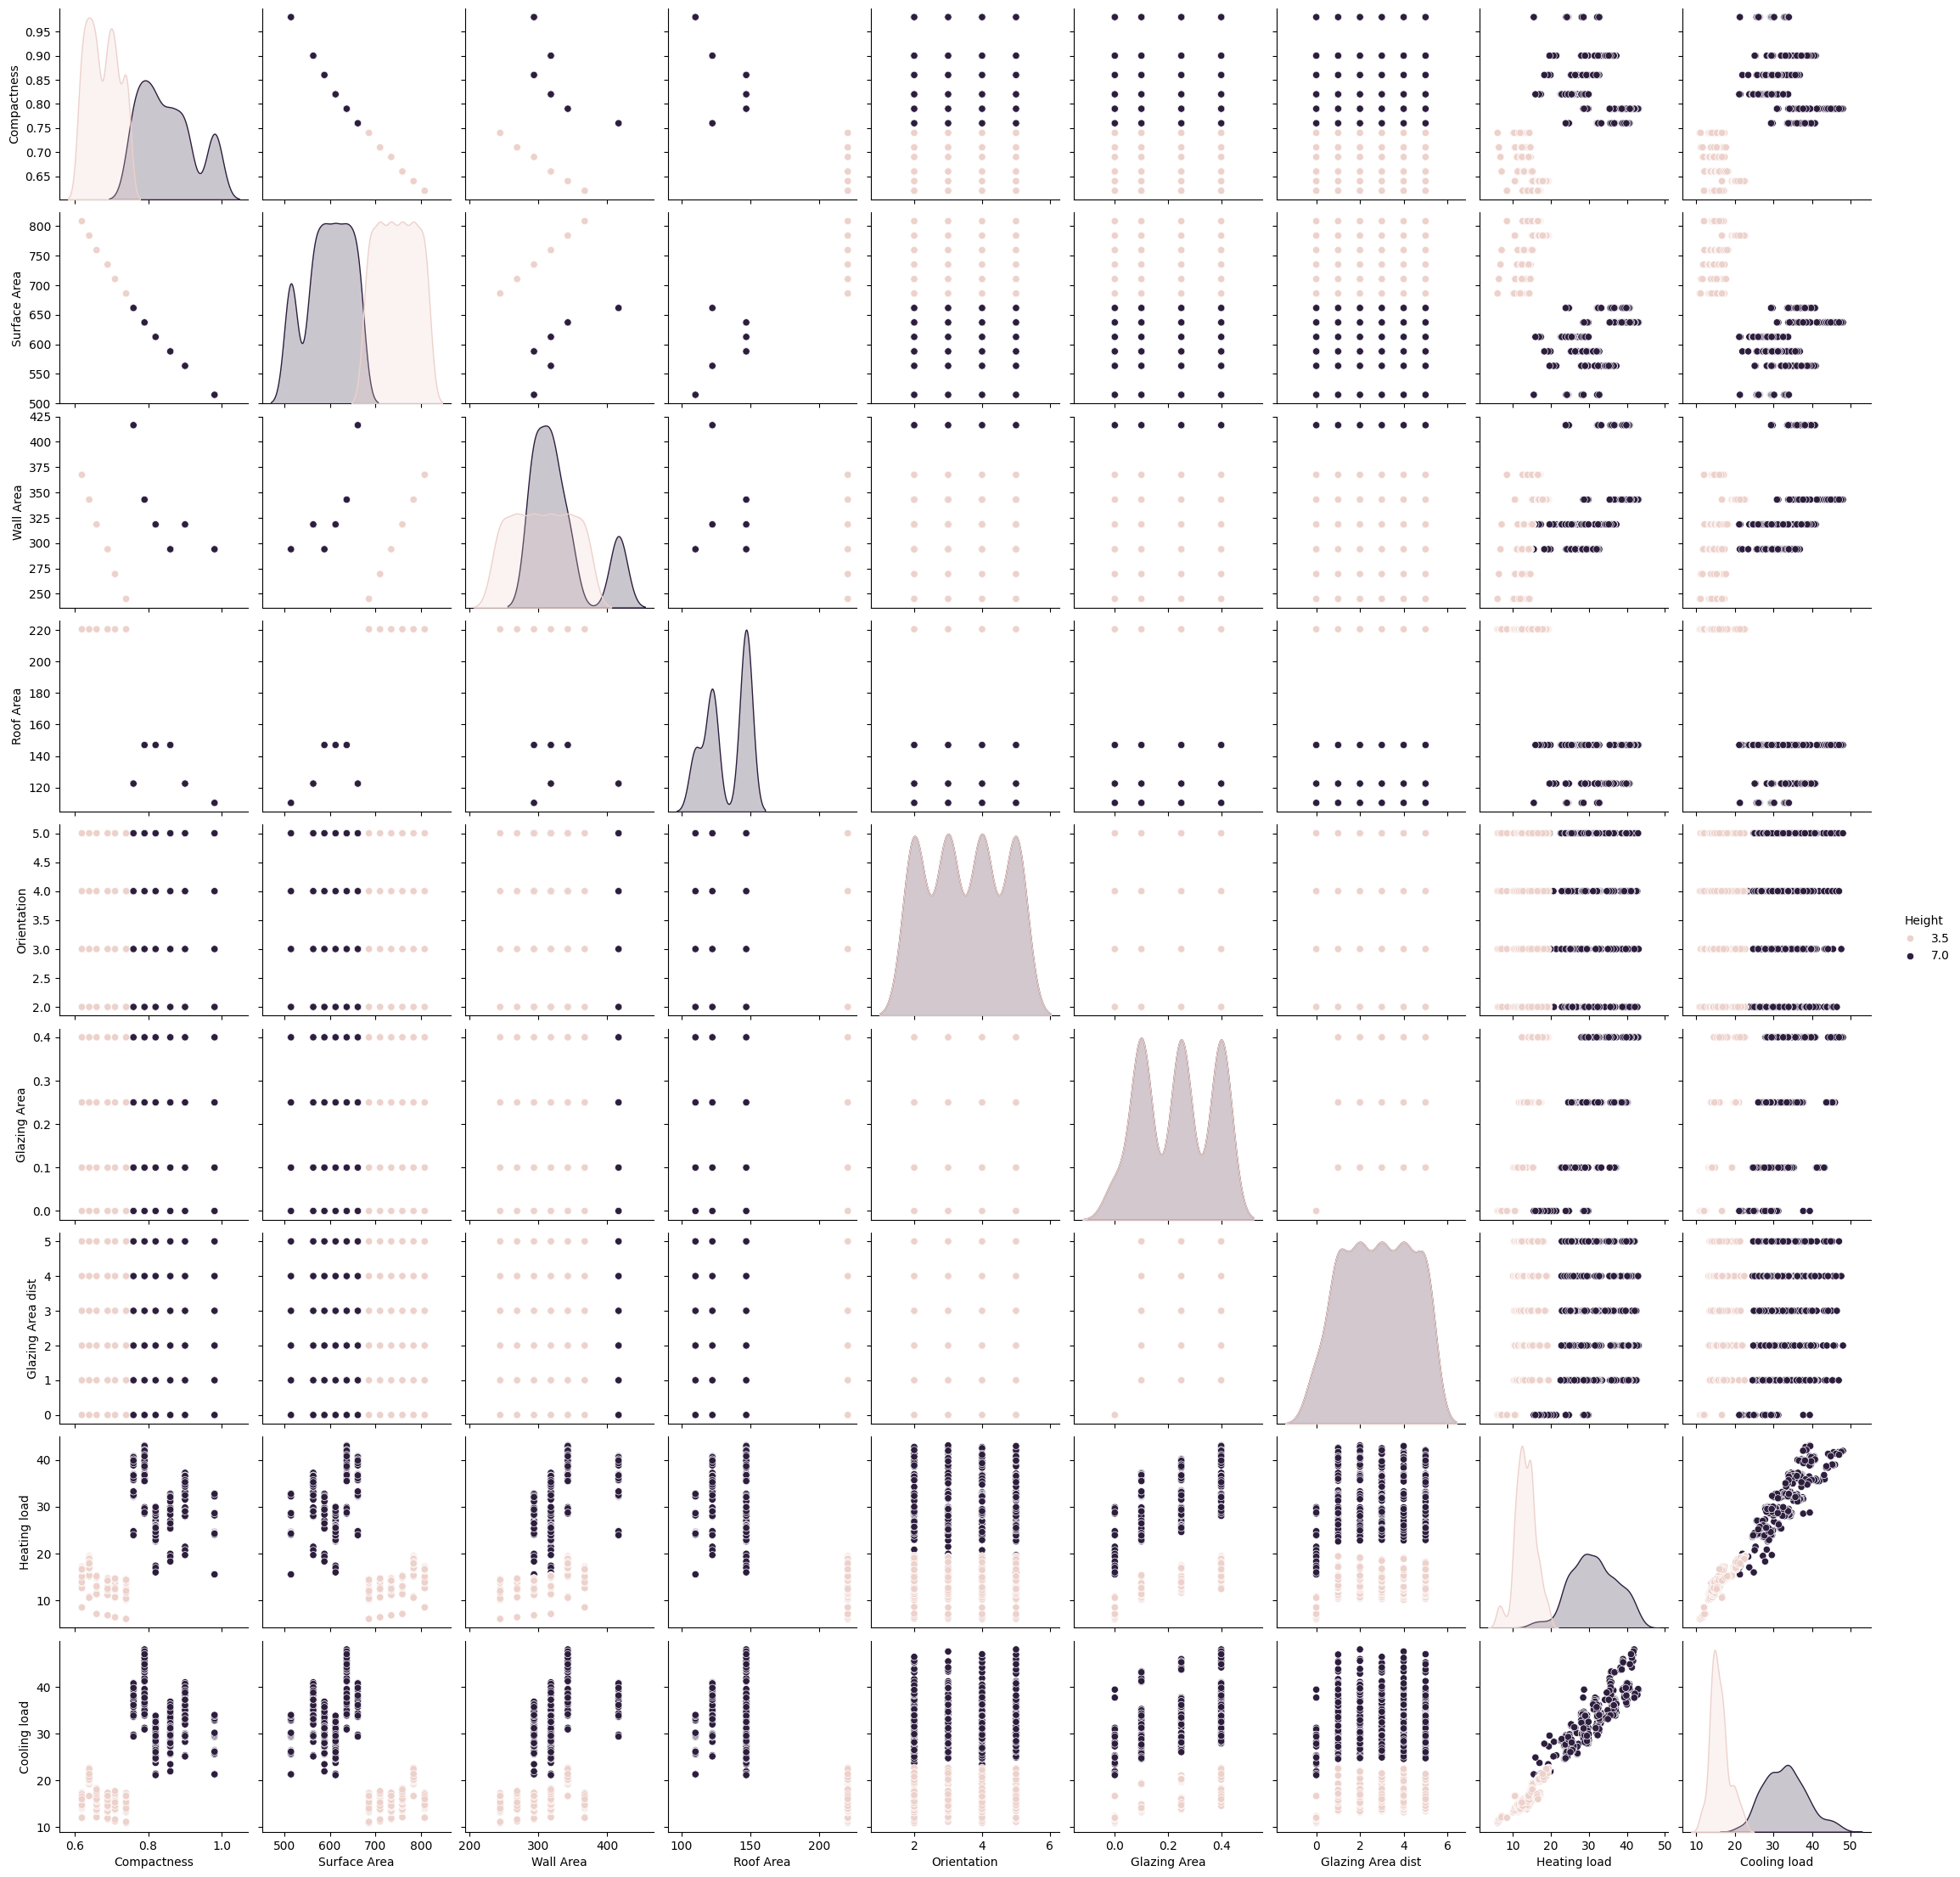

In [17]:
import seaborn
import matplotlib.pyplot as plt
seaborn.pairplot(df, hue='Height')
# to show
plt.show()

## Linear Regression Model

In [18]:
#Target values
y1 = dataset['Y1']
y2 = dataset['Y2']

In [19]:
#Heating Load - Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.2, random_state = 12)
print('Heating Load - Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y1, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))



Heating Load - Linear Regression - all X variables
Training data score: 0.918
Testing data score: 0.902
Average cross validation score: 0.889


c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\A

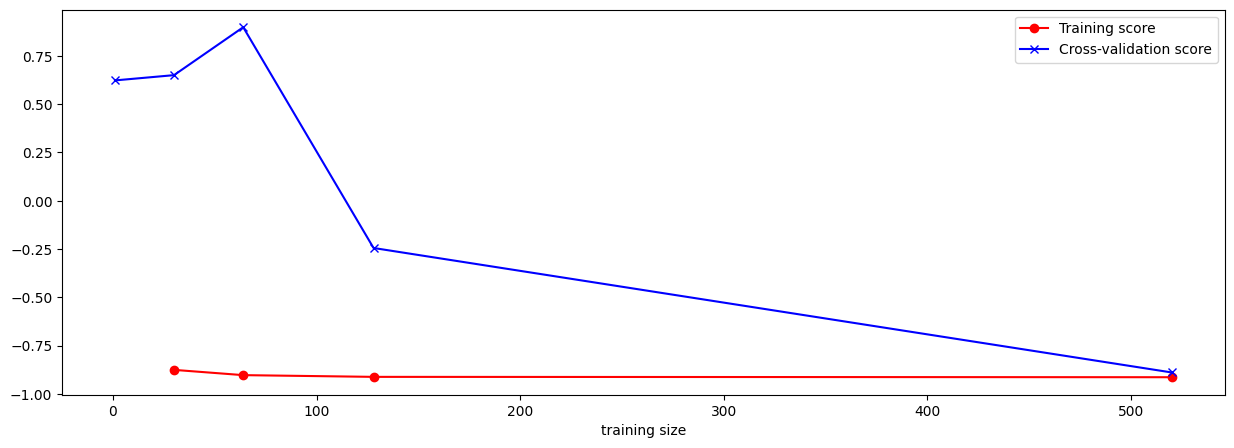

In [20]:

from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator,x,y1,train_sizes = [1,30,64,128,520]):
    train_sizes,train_scores,test_scores = learning_curve(estimator,x,y1,train_sizes = train_sizes,cv=5)

    mean_train_score = -np.mean(train_scores,axis=1)
    mean_test_score = -np.mean(test_scores,axis=1)

    plt.figure(figsize = (15,5))
    plt.xlabel('training size')
    #plt.ylabel('Test')
    plt.plot(train_sizes,mean_train_score,'-o',color='r',label="Training score")
    plt.plot(train_sizes,mean_test_score,'x-',color='b',label="Cross-validation score")
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(lr,x,y1)

In [21]:
#Heating Load - Polynomial Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
x1p = np.array(x)
y1p = np.array(y1)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y1p, test_size = 0.2, random_state = 12)
print('Heating Load - Polynomial Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y1p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Heating Load - Polynomial Linear Regression - all X variables
Training data score: 0.992
Testing data score: 0.992
Average cross validation score: 0.966


In [22]:
#Heating Load - Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y1, test_size = 0.2, random_state = 12)
print('Heating Load - Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y1, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Heating Load - Linear Regression - reduced X variables
Training data score: 0.904
Testing data score: 0.88
Average cross validation score: 0.872


In [23]:
#Heating Load - Polynomial Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]
x1p = np.array(x)
y1p = np.array(y1)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y1p, test_size = 0.2, random_state = 12)
print('Heating Load - Polynomial Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y1p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Heating Load - Polynomial Linear Regression - reduced X variables
Training data score: 0.981
Testing data score: 0.98
Average cross validation score: 0.945


In [24]:
#Cooling Load - Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
X_train, X_test, y_train, y_test = train_test_split(x,y2, test_size = 0.2, random_state = 12)
print('Cooling Load - Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y2, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Linear Regression - all X variables
Training data score: 0.895
Testing data score: 0.861
Average cross validation score: 0.874


c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\A

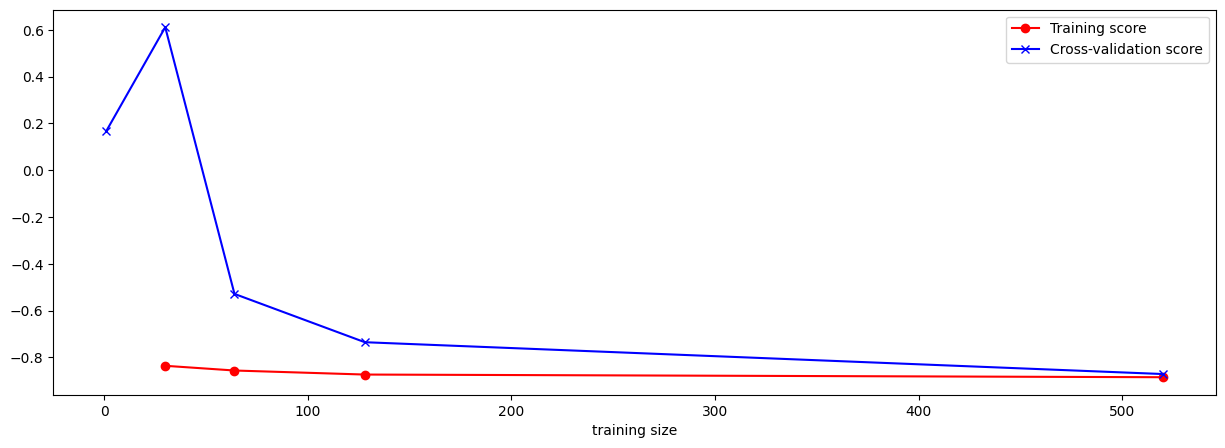

In [25]:

from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator,x,y2,train_sizes = [1,30,64,128,520]):
    train_sizes,train_scores,test_scores = learning_curve(estimator,x,y2,train_sizes = train_sizes,cv=5)

    mean_train_score = -np.mean(train_scores,axis=1)
    mean_test_score = -np.mean(test_scores,axis=1)

    plt.figure(figsize = (15,5))
    plt.xlabel('training size')
    #plt.ylabel('Test')
    plt.plot(train_sizes,mean_train_score,'-o',color='r',label="Training score")
    plt.plot(train_sizes,mean_test_score,'x-',color='b',label="Cross-validation score")
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(lr,x,y2)

In [26]:
#Cooling Load - Polynomial Linear Regression - all X variables
x = dataset[['X1','X2','X3','X4','X5','X6','X7','X8']]
x1p = np.array(x)
y2p = np.array(y2)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y2p, test_size = 0.2, random_state = 12)
print('Cooling Load - Polynomial Linear Regression - all X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y2p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Polynomial Linear Regression - all X variables
Training data score: 0.962
Testing data score: 0.953
Average cross validation score: 0.93


In [27]:
#Cooling Load - Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]

X_train, X_test, y_train, y_test = train_test_split(x,y2, test_size = 0.2, random_state = 12)
print('Cooling Load - Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x,y2, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Linear Regression - reduced X variables
Training data score: 0.877
Testing data score: 0.832
Average cross validation score: 0.855


In [28]:
#Cooling Load - Polynomial Linear Regression - reduced X variables
#dropping X2 and X5 for high correlation to X1 and X4, respectively
x = dataset[['X1','X3','X4','X6','X7','X8']]
x1p = np.array(x)
y2p = np.array(y2)

pf = PolynomialFeatures(degree = 2)
x_poly = pf.fit_transform(x1p)
X_train, X_test, y_train, y_test = train_test_split(x_poly,y2p, test_size = 0.2, random_state = 12)
print('Cooling Load - Polynomial Linear Regression - reduced X variables')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training data score:', round(lr.score(X_train, y_train),3))
print('Testing data score:', round(lr.score(X_test, y_test),3))

kfold_cv = KFold(n_splits = 5)
cv = cross_validate(LinearRegression(), x_poly,y2p, cv = kfold_cv)
print('Average cross validation score:',round(cv['test_score'].mean(),3))

Cooling Load - Polynomial Linear Regression - reduced X variables
Training data score: 0.951
Testing data score: 0.941
Average cross validation score: 0.935


# Decision Tree Model 

In [29]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import AdaBoostRegressor

model = DecisionTreeRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
model.score(X_test,y_test)

0.908204481496595

c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\A

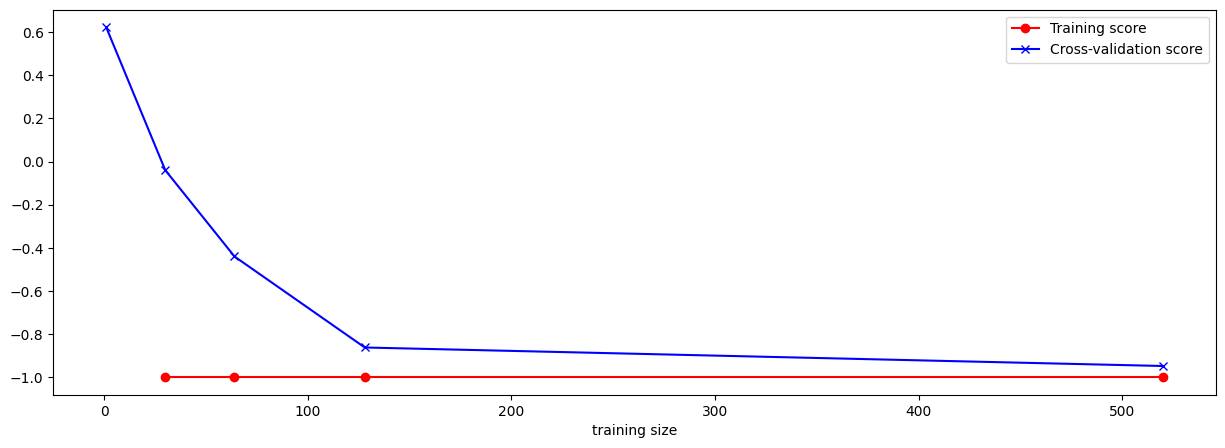

In [30]:
# <b> Plot Heating load - y1 

plot_learning_curve(model,x,y1.values.ravel())

c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Jorge Pedroza\A

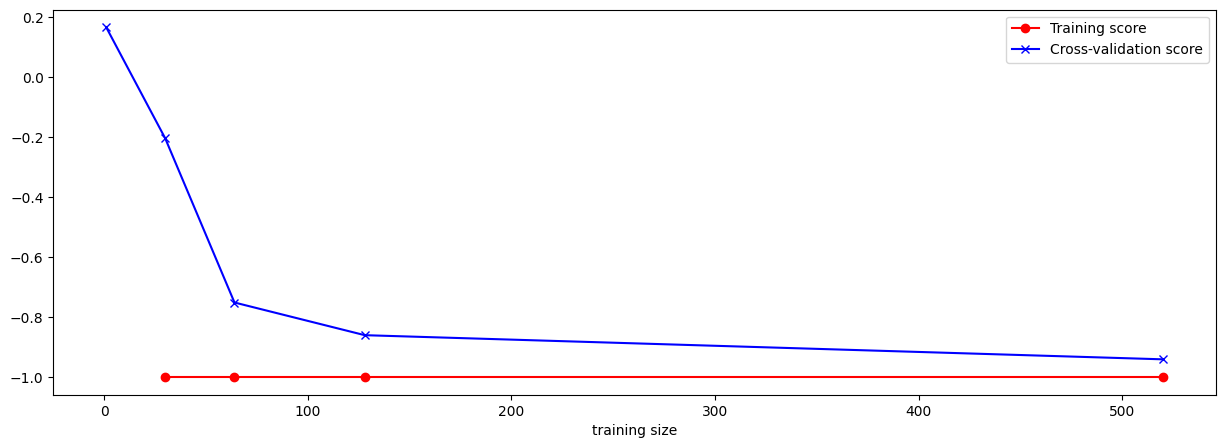

In [31]:
#<b> Plot the Cooling load - y2

plot_learning_curve(model,x,y2.values.ravel())

<B> Visualization:  actual values versus predictions

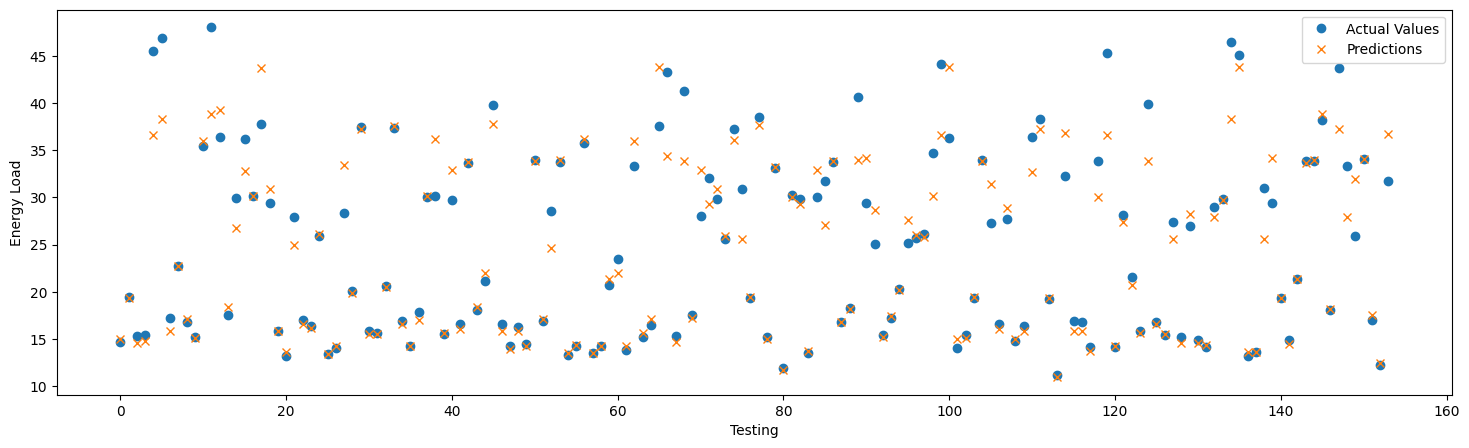

In [32]:
# Create a new figure with a specified size
plt.figure(figsize=(18, 5))

# Plot the actual values with 'o' marker
plt.plot(range(0, len(X_test)), y_test, 'o', label='Actual Values')

# Plot the predicted values with 'x' marker
plt.plot(range(0, len(X_test)), predictions, 'x', label='Predictions')

# Set the x-axis label
plt.xlabel('Testing')

# Set the y-axis label
plt.ylabel('Energy Load')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model for Heating Load
rf_model.fit(X_train, y_train)
print('Random Forest Regressor - Heating Load')
print('Training data score:', round(rf_model.score(X_train, y_train), 3))
print('Testing data score:', round(rf_model.score(X_test, y_test), 3))

# Fit the model for Cooling Load
rf_model.fit(X_train, y_train)
print('Random Forest Regressor - Cooling Load')
print('Training data score:', round(rf_model.score(X_train, y_train), 3))
print('Testing data score:', round(rf_model.score(X_test, y_test), 3))

Random Forest Regressor - Heating Load
Training data score: 0.995
Testing data score: 0.96
Random Forest Regressor - Cooling Load
Training data score: 0.995
Testing data score: 0.96


Heating Load Model Comparison:
                          Model  Training Score  Testing Score
0             Linear Regression        0.950566       0.940666
1  Polynomial Linear Regression        0.979707       0.956806
2       Decision Tree Regressor        1.000000       0.906074
3       Random Forest Regressor        0.994601       0.960092

Cooling Load Model Comparison:
                          Model  Training Score  Testing Score
0             Linear Regression        0.950566       0.940666
1  Polynomial Linear Regression        0.979707       0.956806
2       Decision Tree Regressor        1.000000       0.903694
3       Random Forest Regressor        0.994601       0.960092


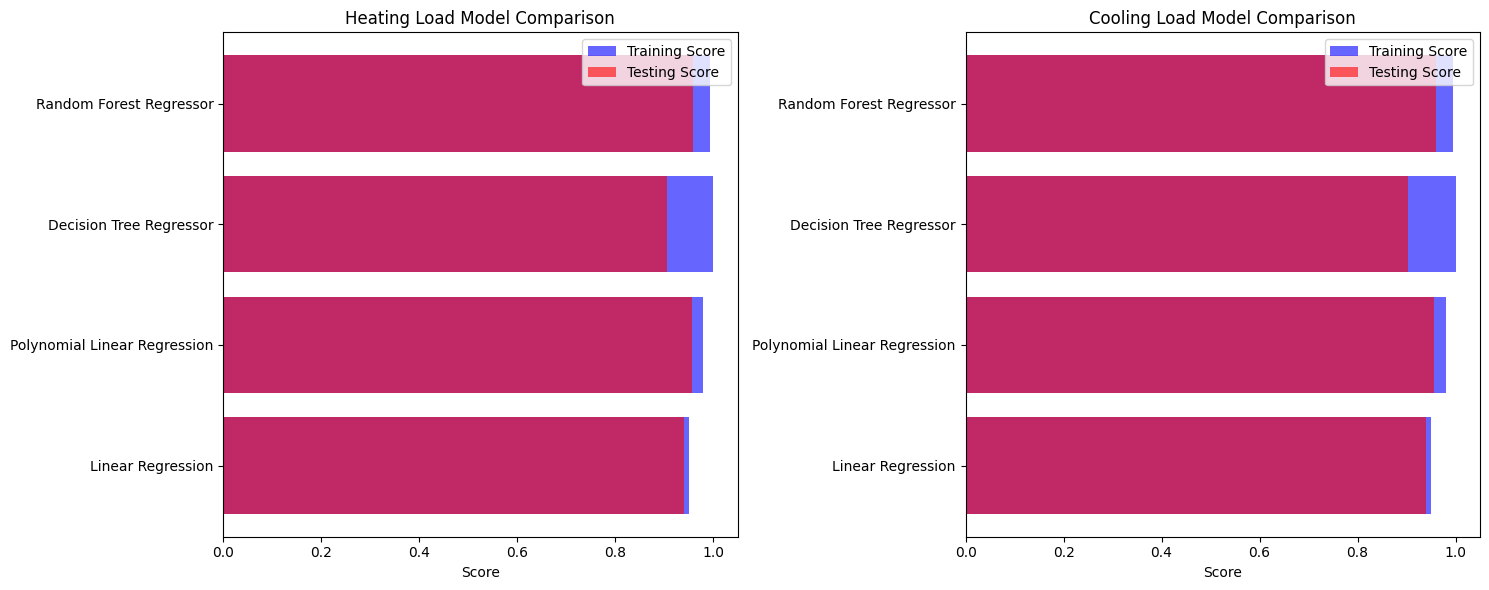

In [34]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluate models for Heating Load
heating_scores = []
for name, model in models.items():
    if name == 'Polynomial Linear Regression':
        pf = PolynomialFeatures(degree=2)
        X_train_poly = pf.fit_transform(X_train)
        X_test_poly = pf.transform(X_test)
        train_score, test_score = evaluate_model(model, X_train_poly, X_test_poly, y_train, y_test)
    else:
        train_score, test_score = evaluate_model(model, X_train, X_test, y_train, y_test)
    heating_scores.append((name, train_score, test_score))

# Evaluate models for Cooling Load
cooling_scores = []
for name, model in models.items():
    if name == 'Polynomial Linear Regression':
        pf = PolynomialFeatures(degree=2)
        X_train_poly = pf.fit_transform(X_train)
        X_test_poly = pf.transform(X_test)
        train_score, test_score = evaluate_model(model, X_train_poly, X_test_poly, y_train, y_test)
    else:
        train_score, test_score = evaluate_model(model, X_train, X_test, y_train, y_test)
    cooling_scores.append((name, train_score, test_score))

# Create DataFrames for the scores
heating_df = pd.DataFrame(heating_scores, columns=['Model', 'Training Score', 'Testing Score'])
cooling_df = pd.DataFrame(cooling_scores, columns=['Model', 'Training Score', 'Testing Score'])

# Display the DataFrames
print("Heating Load Model Comparison:")
print(heating_df)
print("\nCooling Load Model Comparison:")
print(cooling_df)

# Plot the scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heating Load
axes[0].barh(heating_df['Model'], heating_df['Training Score'], color='blue', alpha=0.6, label='Training Score')
axes[0].barh(heating_df['Model'], heating_df['Testing Score'], color='red', alpha=0.6, label='Testing Score')
axes[0].set_title('Heating Load Model Comparison')
axes[0].set_xlabel('Score')
axes[0].legend()

# Cooling Load
axes[1].barh(cooling_df['Model'], cooling_df['Training Score'], color='blue', alpha=0.6, label='Training Score')
axes[1].barh(cooling_df['Model'], cooling_df['Testing Score'], color='red', alpha=0.6, label='Testing Score')
axes[1].set_title('Cooling Load Model Comparison')
axes[1].set_xlabel('Score')
axes[1].legend()

plt.tight_layout()
plt.show()